# GAN for mnist datasets

## 1. 导入相关库并配置GPU

In [1]:
from tensorflow import keras
from tensorflow.keras import layers, optimizers
import numpy as np
from tensorflow.keras.preprocessing import image

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.compat.v1.keras.backend import set_session
from tensorflow.compat.v1 import ConfigProto, Session
config = ConfigProto(allow_soft_placement=True)
config.gpu_options.per_process_gpu_memory_fraction = 0.7
set_session(Session(config=config))

from matplotlib import pyplot as plt

## 2. 先加载数据

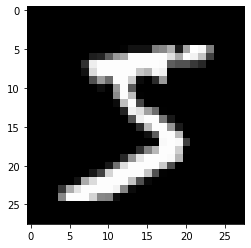

In [2]:
(X_train, Y_train), (_, _) = keras.datasets.mnist.load_data()
X_train = ((X_train.reshape(X_train.shape+(1,)) - 127.5) / 127.5).astype('float64')
plt.imshow(X_train[0], cmap='gray')

## 3. 准备Generator

In [3]:
latent_dim = 100    # 潜在空间
width = 28
height = 28
channels = 1

# generator的输入为种子 和 标签
Generator_input = keras.Input(shape=(latent_dim,))
Label_input = keras.Input(shape=(1,))

x = layers.Dense(7*7*64)(Generator_input)
x = layers.LeakyReLU()(x)

x = layers.Reshape((7, 7, 64))(x)

y = layers.Embedding(10, 50)(Label_input)
y = layers.Dense(49)(y)
y = layers.LeakyReLU(alpha=0.2)(y)

y = layers.Reshape((7, 7, 1))(y)

z = layers.Concatenate()([x, y])
# outputs 7*7*65

z = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same')(z)
z = layers.LeakyReLU(alpha=0.2)(z)
#outputs 14×14×64

z = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same')(z)
z = layers.LeakyReLU(alpha=0.2)(z)


z = layers.Conv2D(1, (7, 7), padding='same', activation='tanh')([Generator_input, Label_input], z)
generator.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        500         input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 3136)         316736      input_1[0][0]                    
______________________________________________________________________________________________

## 4. Discriminator 

In [4]:
discriminator_input = keras.Input(shape=(28, 28, 1,))
label_input = keras.Input(shape=(1,))

l = layers.Embedding(10, 50)(label_input)
l = layers.Dense(28*28)(l)
l = layers.Reshape((28, 28, 1))(l)

x = layers.Concatenate()([discriminator_input, l])

x = layers.Conv2D(64, (3, 3))(x)
x = layers.LeakyReLU(alpha=0.2)(x)

x = layers.Conv2D(128, (4, 4), strides=(2, 2))(x)
x = layers.LeakyReLU(alpha=0.2)(x)

x = layers.Conv2D(128, (4, 4), strides=(2, 2))(x)
x = layers.LeakyReLU(alpha=0.2)(x)

x = layers.Flatten()(x)

x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model([discriminator_input, label_input], x)
opt = optimizers.Adam(
    lr = 0.0004,
    decay = 1e-8,
    clipvalue = 1.0,
    beta_1 = 0.5
)
discriminator.compile(
    loss = 'binary_crossentropy',
    optimizer = opt
)
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        500         input_4[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1, 784)       39984       embedding_1[0][0]                
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
____________________________________________________________________________________________

## 5. 搭建CGAN

In [5]:

gan_input = keras.Input(shape=(latent_dim,))
gan_label = keras.Input(shape=(1,))

gan_output = discriminator([generator([gan_input, gan_label]), gan_label])

gan = keras.models.Model([gan_input, gan_label], gan_output)
gan.get_layer('model_1').trainable = False
gan.summary()
opt_gan = optimizers.Adam(
    lr = 0.0002,
    beta_1 = 0.5,
    clipvalue = 1.0,
    decay = 1e-8
)
gan.compile(
    optimizer = opt_gan,
    loss = 'binary_crossentropy'
)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 28, 28, 1)    455096      input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 1)            438373      model[0][0]                

In [6]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        500         input_4[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1, 784)       39984       embedding_1[0][0]                
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
____________________________________________________________________________________________

## 6. 训练CGAN

In [8]:
import os
iterations = 50000
start = 10000
batch_size = 128
img_path = '/home/oneran/GAN_pictures/mnist'

for step in range(iterations):
    random_latent_vector = np.random.normal(size=(batch_size, latent_dim))
    random_generated_label = np.random.randint(0, 10, batch_size)
    generated_img = generator.predict([random_latent_vector, random_generated_label])
    img_label = random_generated_label[0]

    stop = start + batch_size
    real_img = X_train[start: stop]
    
    combined_img = np.concatenate([generated_img, real_img])
    combined_label = np.concatenate(
        [np.ones((batch_size, 1)),
        np.zeros((batch_size, 1))]
    )

    # 加入噪音 使得标签平滑化
    combined_label += 0.05 * np.random.random(size=combined_label.shape)

    loss_d = discriminator.train_on_batch([combined_img, np.concatenate([random_generated_label, Y_train[start: stop]])], combined_label)

    random_latent_vector = np.random.normal(size=(batch_size, latent_dim))
    random_generated_label = np.random.randint(0, 10, batch_size)
    
    misleading_labels = np.zeros(shape=(batch_size, 1))

    loss_a = gan.train_on_batch([random_latent_vector, random_generated_label], misleading_labels)
    
    start += batch_size
    
    if start > len(X_train) - batch_size:
        start = 0
    
    if step % 100 == 0:
        gan.save_weights('gan.h5')

        print('generator at loss:', loss_a)
        print('discriminator at loss:', loss_d)
        
        img = image.array_to_img(generated_img[0]*127.5+127.5, scale=False)
        img.save(os.path.join(img_path, 'generated_num_'+str(step)+'_'+str(img_label)+'.png'))
        
        img = image.array_to_img(real_img[0]*127.5+127.5, scale=False)
        img.save(os.path.join(img_path, 'real_num_'+str(step)+'.png'))


generator at loss: 1.3992018699645996
discriminator at loss: 0.5379870533943176
generator at loss: 4.564394474029541
discriminator at loss: 0.2086048126220703
generator at loss: 3.8909831047058105
discriminator at loss: 0.19809186458587646
generator at loss: 3.396646022796631
discriminator at loss: 0.3344482481479645
generator at loss: 1.3252134323120117
discriminator at loss: 0.4939238131046295
generator at loss: 3.06857967376709
discriminator at loss: 0.29757529497146606
generator at loss: 4.336404800415039
discriminator at loss: 0.2723967432975769
generator at loss: 3.224268913269043
discriminator at loss: 0.2629949748516083
generator at loss: 3.373918056488037
discriminator at loss: 0.2663515508174896
generator at loss: 2.4209842681884766
discriminator at loss: 0.2834509313106537
generator at loss: 4.233179569244385
discriminator at loss: 0.38202449679374695
generator at loss: 2.2952303886413574
discriminator at loss: 0.27787086367607117
generator at loss: 3.1013519763946533
discri

KeyboardInterrupt: 

In [9]:
gan.save('/home/oneran/Models/gan.h5')

In [10]:
generator.save('/home/oneran/Models/mnist_generator.h5')